# APT Factor Model

In [1]:
import pickle
import bz2
import numpy as np
import pandas as pd
import math
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from matplotlib.pyplot import figure
from scipy.optimize import minimize
from scipy.linalg import sqrtm

## Helper Functions

In [2]:
def load_data(file_name):
    """
    Loads the  data from local system given the name of the file
    
    returns dataframe 
    """
    data_df = pickle.load( bz2.open( file_name, "rb" ) )
    return pd.concat([data_df[i] for i in data_df.keys()])

def sort_cols(df):
    '''
    Sorts the columns of the dataframe in an alphabetical manner
    df: dataframe
    
    returns sorted dataframe
    '''
    sorted_df = df.reindex(sorted(df.columns),axis = 1)
    return sorted_df

def wins(x,a,b):
    '''
    Winsorizes the array based on threshold limits(Hard bounds). Limits x to a lower bound "a" and an upper bound "b"
    x: array
    a: lower bound float
    b: upper bound float
    
    returns winsorized array
    
    '''
    x = np.where(x >= b, b , x)
    x = np.where(x <= a, a , x)
    return x

def clean_nas(df):
    '''
    cleans the dataframe by converting the nan values
    df: dataframe
    
    returns dataframe without NAs
    '''
    #All NAs are numeric columns
    return df.apply(np.nan_to_num)

def density_plot(data, title):
    '''
    Plots density plot with the given data file and title of the plot
    data: dataframe
    title: String
    
    returns density plot
    '''
    sns.kdeplot(data)
    plt.title(title)
    plt.show()
    
def estimate_factor_returns(day_df,estimation_universe_min_cap,factors):
    '''
    Estimates the factor returns using the given factors, filtering on the minimum market cap for the firms
    
    day_df: dataframe
    estimation_universe_min_cap: float
    factors: list
    
    returns factor returns dataframe fac_ret
    '''
    universe_filtered_df = day_df[day_df.IssuerMarketCap > estimation_universe_min_cap]
    X = np.array(universe_filtered_df[factors])
    #ones = np.ones(X.shape[0])[...,None]
    #X = np.append(X,ones,1)
    y = wins(universe_filtered_df['Ret'],-0.25,0.25)
    fac_ret = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
    return fac_ret

def XandD(day_df,estimation_universe_min_cap,factors):
    '''
    Calculates the matrices X and D used for optimization, after filtering out with the universe condition
    
    day_df: dataframe containing all the factors for the particular date
    estimation_universe_min_cap: float minimmum market cap
    factors: list containing factors
    
    returns X (array),D (array), and id_list (array)
    
    '''
    universe_filtered_df = day_df[day_df.IssuerMarketCap > estimation_universe_min_cap]
    X = np.array(universe_filtered_df[factors])
    D = np.array((universe_filtered_df['SpecRisk']*0.01)**2)
    D = np.diag(D)
    id_list = universe_filtered_df.ID.unique()
    return X,D,id_list

def diagonalize_covariance(grouped_covariance,date,factors):
    '''
    Forms the diagonal covariance required for the analysis (F) 
    This function gives the F matrix.
    
    Parameters:
    
    1.grouped covariance: dataframe
    2.date: date in number format
    3.factors: list of factors used 
    
    returns diagonalized matrix
    
    '''
    cov_mat = grouped_covariance.get_group(date)
    cov_mat = cov_mat[cov_mat['Factor1'] == cov_mat['Factor2']]
    cov_mat = cov_mat.pivot(index = 'Factor1',columns = 'Factor2',values ='VarCovar')
    cov_mat = cov_mat[factors].loc[factors]
    cov_mat = np.nan_to_num(cov_mat)
    cov_mat = cov_mat*(1/1e4) #Adjustment Factor
    return cov_mat

def form_optimal_portfolio(X,D,F,mu_f,k):
    '''
    Forms optimal portfolio. 
    
    X: numpy matrix
    D: numpy matrix 
    mu_f: np array
    k: float
    
    '''
    x_opt = (1/k)*np.matmul(np.linalg.inv(F + np.linalg.pinv(np.matmul(np.matmul(X.T,np.linalg.inv(D)),X))),mu_f)
    D_minus_half = sqrtm(np.linalg.inv(D))
    D_minus = np.linalg.inv(D)
    h_opt = np.matmul(np.matmul(D_minus_half,np.linalg.pinv(np.matmul(X.T,D_minus_half))),x_opt)
    return h_opt


def objective_fn(h,D,X,F,mu_f,date):
    #Did not find much use for this function as the closed form matrix solution was enough to calculate the optimal portfolio
    '''
    Returns the objective utility function value. 
    
    h: array
    D: np matrix
    X: np matrix
    F: np matrix
    mu_f: np array
    date: date in float format
    
    returns utility value (float)
    
    '''
    idiosyn_var = np.matmul(np.matmul(h.T,D),h)
    factor_var = np.matmul(np.matmul(h.T,np.matmul(np.matmul(X,F),X.T)),h)
    idiosyn_risk = idiosyn_var**0.5
    factor_risk = factor_var**0.5
    exp_ret = np.matmul(h.T,np.matmul(X,mu_f))
    x = np.matmul(X.T,h)
    Vx = np.matmul(np.matmul(x.T,np.linalg.pinv(np.matmul(np.matmul(X.T,np.linalg.inv(D)),X))),x)
    utility = idiosyn_risk + factor_risk - exp_ret
    return utility

Data is loaded, columns sorted, and cleaned. Then
Running the estimate_factor_returns function to calculate the factor returns for every year. Density plots before and after winsorization are shown. 

In [3]:
factors = ["1DREVRSL", "VALUE", "SENTMT",'GROWTH','LIQUIDTY','MOMENTUM','BETA','SIZE','EARNYILD']
#factors = ['BETA', 'DIVYILD', 'DWNRISK', 'EARNQLTY', 'EARNYILD', 'GROWTH',  'INDMOM', 'LEVERAGE', 'LIQUIDTY', 'LTREVRSL', 'MGMTQLTY', 'MIDCAP', 'MOMENTUM', 'PROFIT', 'PROSPECT', 'RESVOL', 'SEASON','SENTMT', 'SIZE','STREVRSL','VALUE' ]
factor_columns = factors[:]
multi_factor_returns = pd.DataFrame(columns = factor_columns)
for year in np.arange(2003,2011):
    data = load_data("pandas-frames." + str(year) + ".pickle.bz2") #Load Data
    data = sort_cols(data) #Sorting Columns alphabetically
    data = clean_nas(data) #Cleaning NAs    
    date_grouped = data.groupby(by = 'DataDate') #Grouping data to perform crosssection regressions
    factor_returns = pd.DataFrame(columns = factor_columns)
    exp = date_grouped.apply(estimate_factor_returns,estimation_universe_min_cap = 1e9,factors=factors)
    index = pd.DataFrame(exp).index
    factor_returns = pd.DataFrame(exp.to_list(), columns = factor_columns,index = pd.to_datetime(index,format='%Y%m%d'))
    multi_factor_returns = multi_factor_returns.append(factor_returns)
    del data

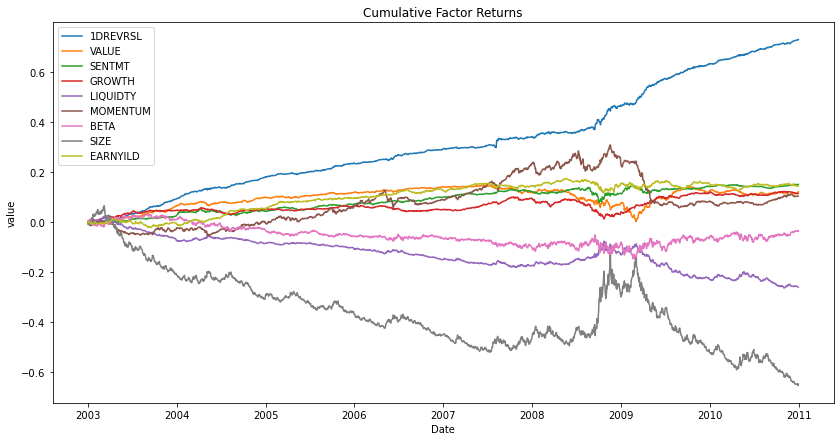

In [4]:
plt.figure(figsize=(14,7))
plt.plot(multi_factor_returns.cumsum())
plt.title('Cumulative Factor Returns')
plt.xlabel('Date')
plt.ylabel('value')
plt.legend(multi_factor_returns.columns,loc='upper left')
plt.show()
multi_factor_returns.to_csv('FactorReturns.csv')

## Alpha Generation

The idea is to generate the factor returns using the styles and industries first using cross-sectional regressions. Then an n day rolling average is taken to compute the factor returns for the present day (i.e using n days average (t-n,t-1) for factor returns at time t). The idea is simple, assuming that the Expected returns is a linear combimation of factor returns (averaged over n days)

In [5]:
year_start = 2003
year_end = 2004
#industries = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO', 'BANKS', 'BEVTOB', 'BIOLIFE', 'BLDGPROD', 'CHEM', 'CNSTENG',  'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC', 'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB', 'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL', 'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR', 'INDMACH', 'INSURNCE', 'INTERNET', 'LEISPROD', 'LEISSVCS',  'LIFEINS', 'MEDIA', 'MGDHLTH', 'MULTUTIL', 'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA', 'PRECMTLS', 'PSNLPROD', 'REALEST', 'RESTAUR', 'ROADRAIL', 'SEMICOND', 'SEMIEQP', 'SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT','WIRELESS']
styles = ['BETA', 'DIVYILD', 'DWNRISK', 'EARNQLTY', 'EARNYILD', 'GROWTH',  'INDMOM', 'LEVERAGE', 'LIQUIDTY', 'LTREVRSL', 'MGMTQLTY', 'MIDCAP', 'MOMENTUM', 'PROFIT', 'PROSPECT', 'RESVOL', 'SEASON','SENTMT', 'SIZE','STREVRSL','VALUE' ]
style_list = styles #+ industries
factor_columns = style_list[:]
alpha_returns = pd.DataFrame(columns = factor_columns)
for year in np.arange(year_start,year_end):
    data = load_data("pandas-frames." + str(year) + ".pickle.bz2") #Load Data
    data = sort_cols(data) #Sorting Columns alphabetically
    data = clean_nas(data) #Cleaning NAs    
    date_grouped = data.groupby(by = 'DataDate') #Grouping data to perform crosssection regressions
    factor_returns = pd.DataFrame(columns = factor_columns)
    exp = date_grouped.apply(estimate_factor_returns,estimation_universe_min_cap = 1e9,factors=factor_columns)
    index = pd.DataFrame(exp).index
    factor_returns = pd.DataFrame(exp.to_list(), columns = factor_columns,index = pd.to_datetime(index,format='%Y%m%d'))
    alpha_returns = alpha_returns.append(factor_returns)
    del data
alpha_roll = alpha_returns.rolling(10).mean().shift(1).dropna()

For optimization, instead of using all the years, I used only 1 year worth data to reduce the calculation time, and also I was not able to merge all the data files into a single master file because of memory overload. Maybe that was not the right thing to do to merge all the files into one. Vectorizing the optimization function would have been a better solution

In [6]:
master_df = pd.DataFrame()
for year in np.arange(year_start,year_end):
    data = load_data("pandas-frames." + str(year) + ".pickle.bz2") #Load Data
    data = sort_cols(data) #Sorting Columns alphabetically
    data = clean_nas(data) #Cleaning NAs    
    master_df = pd.concat([master_df,data])
    del data
    
master_cov = pd.DataFrame()
for year in np.arange(year_start,year_end):
    data = load_data("covariance." + str(year) + ".pickle.bz2") #Load Data
    master_cov = pd.concat([master_cov,data])
    del data

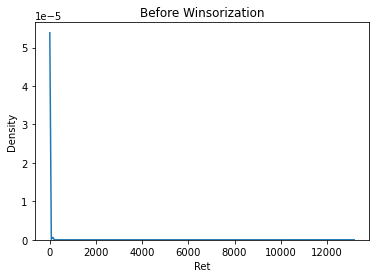

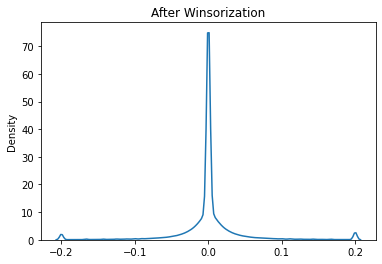

In [15]:
density_plot(master_df['Ret'],'Before Winsorization') #Plotting returns before winsorization
density_plot(wins(master_df['Ret'],-0.2,0.2),'After Winsorization') #Plotting after winsorization

## Closed Form solution instead of opimizing it eveyday using a solver

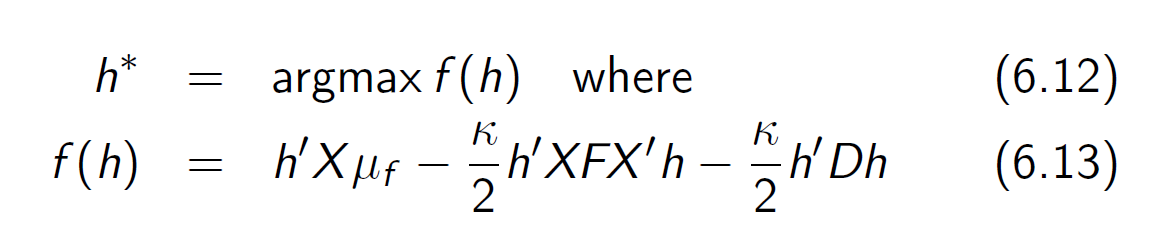

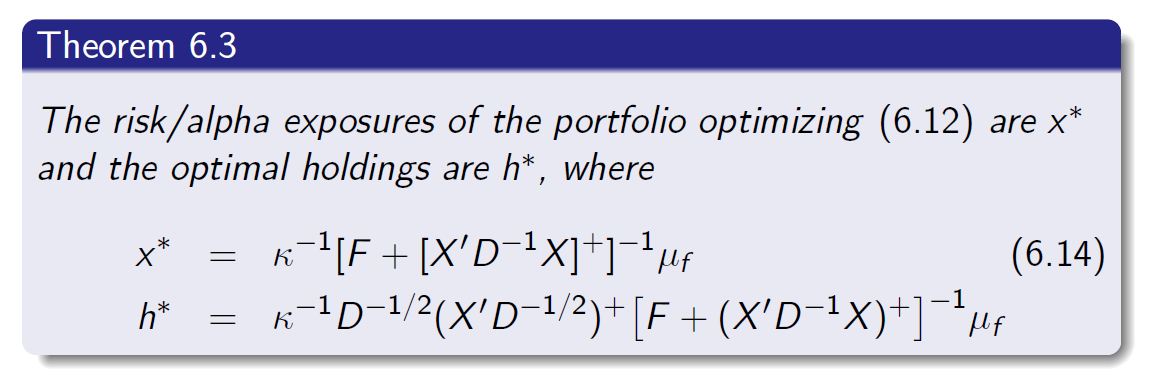

## 1. Without Transaction costs

In [7]:
holdings_df = pd.DataFrame()
for date in sorted(master_cov.DataDate.unique()):
    date_grouped = master_df.groupby(by = 'DataDate')
    X,D,id_list = XandD(date_grouped.get_group(date),1e9,style_list)
    cov_grouped = master_cov.groupby(by = "DataDate")
    F = diagonalize_covariance(cov_grouped,date,style_list)
    mu_f = alpha_returns.loc[pd.to_datetime(date,format='%Y%m%d')]
    h = form_optimal_portfolio(X,D,F,mu_f,2)
    h = pd.Series(h,index = id_list)
    holdings_df[date] = h 

In [8]:
holdings = holdings_df.T
actual_ret = master_df[['DataDate','Ret','ID']].pivot(index = 'DataDate',columns = 'ID',values = 'Ret')
actual_ret = actual_ret[holdings.columns]
actual_ret = actual_ret.T[holdings.index]

Text(0, 0.5, 'value')

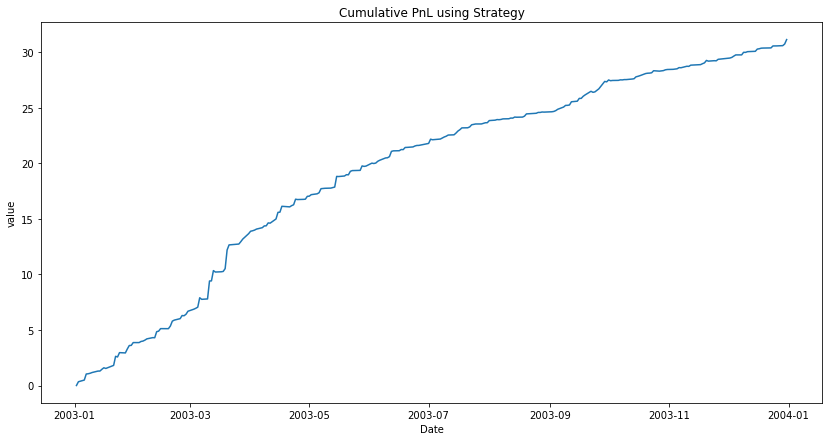

In [9]:
hol_diff = holdings.diff()
plt.figure(figsize=(14,7))
pnl_without_costs = pd.DataFrame(np.cumsum(np.sum(pd.DataFrame((np.nan_to_num(hol_diff)*np.nan_to_num(actual_ret.T))),axis =1 )))
pnl_without_costs.index = pd.to_datetime(holdings.index,format='%Y%m%d')
plt.plot(pnl_without_costs)
plt.title('Cumulative PnL using Strategy')
plt.xlabel('Date')
plt.ylabel('value')

The holdings timeseries difference is taken and multiplied with the returns vector for each date and summed up to get daily PnL. Then the daily PnL is cumulatively summed across the dates and a cumulative PnL is formed. Here, I noticed that the sharpe ratio is high. It was a bit surprising with such simplistic assumptions. However, I have taken care not to have any forward bias and have not used future data to predict the current holdings

In [10]:
sharpe_without_costs = np.mean(pnl_without_costs[1:].pct_change(1))/np.std(pnl_without_costs[1:].pct_change(1))*math.sqrt(252)
print('Sharpe ratio without transaction costs is',sharpe_without_costs.values[0])

Sharpe ratio without transaction costs is 3.8538434585319528


## 2. With Transaction Costs (Quadratic Transaction Cost model)

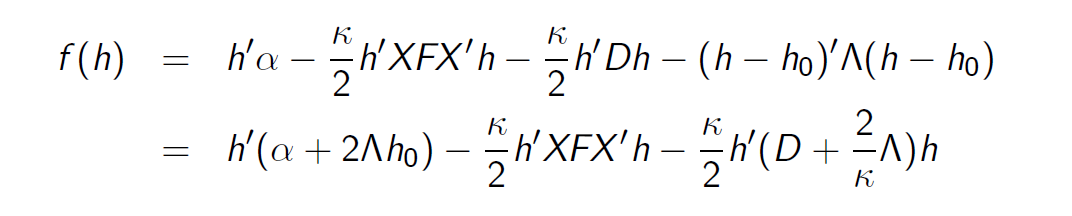

Solving theabove objective function for x and h, and optimizing it, we have
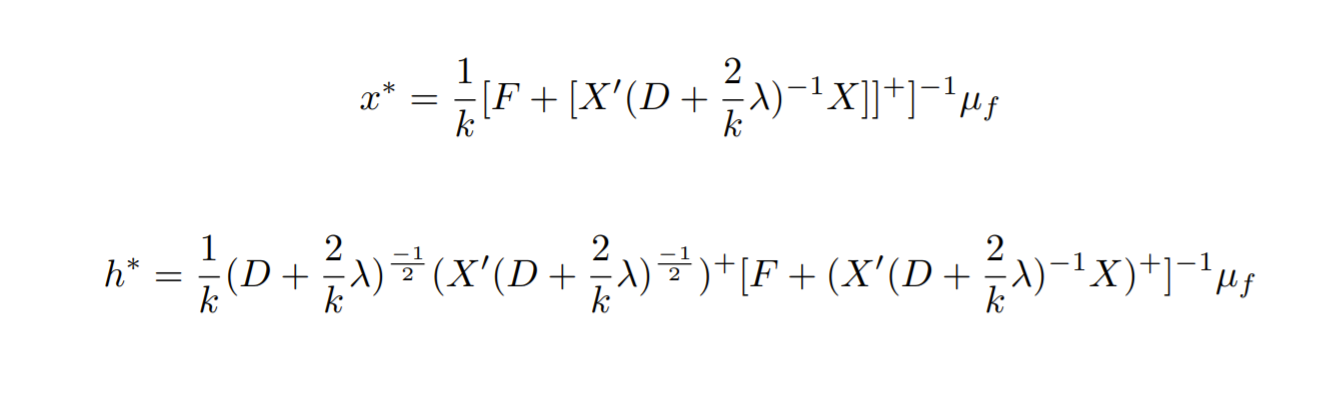

With the above mentioned objective function above, we have the optimal holidings vector similar to that of the case without trasaction costs. This is because of the similar form of objective function to mean-variance objective function without transaction costs. Modifying D and adding a lambda parameter (Assuming all lambdas = constant. Here,  assumed lambda = 0.5. However, it has to be estimated

In [11]:
holdings_df = pd.DataFrame()
lam_bda = 0.5
k = 2
for date in sorted(master_cov.DataDate.unique()):
    date_grouped = master_df.groupby(by = 'DataDate')
    X,D,id_list = XandD(date_grouped.get_group(date),1e9,style_list)
    D = D + (2/k)*lam_bda*np.diag(np.ones(D.shape[0])) #D will be changed here because of inclusion of transaction costs
    cov_grouped = master_cov.groupby(by = "DataDate")
    F = diagonalize_covariance(cov_grouped,date,style_list)
    mu_f = alpha_returns.loc[pd.to_datetime(date,format='%Y%m%d')]
    h = form_optimal_portfolio(X,D,F,mu_f,k)
    h = pd.Series(h,index = id_list)
    holdings_df[date] = h 

In [16]:
holdings = holdings_df.T
actual_ret = master_df[['DataDate','Ret','ID']].pivot(index = 'DataDate',columns = 'ID',values = 'Ret')
actual_ret = actual_ret[holdings.columns]
actual_ret = actual_ret.T[holdings.index]

The holdings timeseries difference is taken and multiplied with the returns vector for each date and summed up to get daily PnL. Then the daily PnL is cumulatively summed across the dates and a cumulative PnL is formed. Here, I noticed that the sharpe ratio is high. It was a bit surprising with such simplistic assumptions. However, I have taken care not to have any forward bias and have not used future data to predict the current holdings.

We can see the effect of having transaction costs in the plot

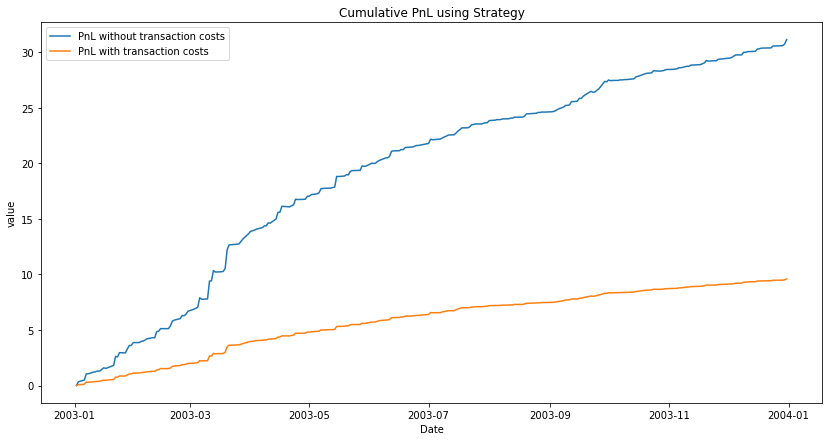

In [13]:
hol_diff = holdings.diff()
plt.figure(figsize=(14,7))
pnl = pd.DataFrame(np.cumsum(np.sum(pd.DataFrame((np.nan_to_num(hol_diff)*np.nan_to_num(actual_ret.T))),axis =1 )))
pnl.index = pd.to_datetime(holdings.index,format='%Y%m%d')
plt.plot(pnl_without_costs)
plt.plot(pnl)
plt.title('Cumulative PnL using Strategy')
plt.legend(['PnL without transaction costs','PnL with transaction costs'],loc='upper left')
plt.xlabel('Date')
plt.ylabel('value')
plt.savefig('Comparison.png')

In [14]:
sharpe_with_costs = (np.mean(pnl[1:].pct_change(1))/np.std(pnl[1:].pct_change(1)))*math.sqrt(252)
print('Sharpe ratio with transaction costs is',sharpe_with_costs.values[0])

Sharpe ratio with transaction costs is 3.3457635979905045


In [ ]:
D_minus_half = sqrtm(np.linalg.inv(D))
D_minus = np.linalg.inv(D)
h_opt = np.matmul(np.matmul(sqrtm(np.linalg.inv(D)),np.linalg.pinv(np.matmul(X.T,sqrtm(np.linalg.inv(D))))),x_star)